# COVID-19

### Several countries are now experiencing sustained local transmission of coronavirus disease 2019 (COVID-19), including Europe.
### The COVID-19 pandemic is rapidly evolving, and outbreak investigations are ongoing. ECDC is closely monitoring this outbreak, providing risk assessments, public health guidance, and advice on response activities to EU Member States and the EU Commission

In [1]:
#Step#1 - Load data
import pandas as pd
train_df = pd.read_excel("G:/DataScienceProject/Coronavirus_ecdc/COVID-19-geographic-disbtribution-worldwide-2020-03-22.xlsx")
train_df = train_df[train_df.GeoId != 'JPG11668']
train_df.drop(['Day', 'Month', 'Year'],inplace=True,axis=1)
train_df.head()

,DateRep,Cases,Deaths,Countries and territories,GeoId
0,2020-03-22,0,0,Afghanistan,AF
1,2020-03-21,2,0,Afghanistan,AF
2,2020-03-20,0,0,Afghanistan,AF
3,2020-03-19,0,0,Afghanistan,AF
4,2020-03-18,1,0,Afghanistan,AF


In [2]:
#Step#2 - Assign continents column by creating a dictionary
#Data is taken from: https://datahub.io/JohnSnowLabs/country-and-continent-codes-list#resource-country-and-continent-codes-list-csv
countriesDic = {}
countries_df = pd.read_csv("G:/DataScienceProject/Coronavirus_ecdc/country-and-continent-codes-list-csv.csv")

for i in range(len(countries_df)):
    countriesDic[countries_df['Two_Letter_Country_Code'].loc[i]] = countries_df['Continent_Name'].loc[i]
    countriesDic[countries_df['Three_Letter_Country_Code'].loc[i]] = countries_df['Continent_Name'].loc[i]


In [3]:
#Step3 - Adding continents into traind_df
GeoIdList = list(train_df['GeoId'].unique())
train_df['Cont'] = train_df['GeoId']
for i, value in enumerate(GeoIdList):
    if countriesDic.get(value) != None:
        train_df['Cont'] = train_df['Cont'].replace(value, countriesDic[value])

train_df.head(1500)

,DateRep,Cases,Deaths,Countries and territories,GeoId,Cont
0,2020-03-22,0,0,Afghanistan,AF,Asia
1,2020-03-21,2,0,Afghanistan,AF,Asia
2,2020-03-20,0,0,Afghanistan,AF,Asia
3,2020-03-19,0,0,Afghanistan,AF,Asia
4,2020-03-18,1,0,Afghanistan,AF,Asia
...,...,...,...,...,...,...
1559,2020-01-26,0,0,Denmark,DK,Europe
1560,2020-01-25,0,0,Denmark,DK,Europe
1561,2020-01-24,0,0,Denmark,DK,Europe
1562,2020-01-23,0,0,Denmark,DK,Europe


As you can see, the above data frame is arranged by calendary days.
For ease I'll shift it into duration (days from the 0d epidamic day)

In [4]:
#Step#4- Adding duration columns
train_df['Duration'] = train_df['DateRep'] - train_df['DateRep'].min()
train_df['Duration'] = train_df['Duration'].dt.days
train_df.head()

,DateRep,Cases,Deaths,Countries and territories,GeoId,Cont,Duration
0,2020-03-22,0,0,Afghanistan,AF,Asia,82
1,2020-03-21,2,0,Afghanistan,AF,Asia,81
2,2020-03-20,0,0,Afghanistan,AF,Asia,80
3,2020-03-19,0,0,Afghanistan,AF,Asia,79
4,2020-03-18,1,0,Afghanistan,AF,Asia,78


## Additional Feature

#### Let's assume the followed assumptions for Corona epidemic:
#### 1.Continent & world total cases & deaths - as we'd like to compare a specific country it shall be compare into its geolocation continet.

#### 2.Population Density per squaure KM - Can we compare a very big country with small amount of population to a small country size in which is population is very densed? For doing this we shall use population density scale. (Data: https://data.worldbank.org/indicator/en.pop.dnst)

#### 3.Human Development Index - Can we compare the above when the small country has very high HDI? Meaning that, the country both monitery capital & infrastructure could be a very good basis to reduce an epidemic. (Data: http://hdr.undp.org/en/data#)

In [5]:
#Step#5 - Convert Cases & Deaths into cumulative
durationList = train_df['Duration'].unique()
CountriesTerritoriesList = train_df['Countries and territories'].unique()
newDF = pd.DataFrame(columns=['Duration', 'Countries', 'Cont', 'AccCases', 'AccDeaths'])
counter = 1
for i, valueA in enumerate(CountriesTerritoriesList):
    tmp = train_df[train_df['Countries and territories'] == valueA]
    cont = list(tmp['Cont'].unique())
    for j, valueB in enumerate(durationList):
         tmp = tmp[tmp['Duration'] <= valueB]
         newDF.loc[counter] = [valueB, valueA, cont[0], tmp['Cases'].sum(), tmp['Deaths'].sum()]
         counter += 1

#Step#6 - Adding world & continent cumulative cases & deaths
newDF['ContAccCases'] = ''
newDF['ContAccDeaths'] = ''
newDF['WorldAccCases'] = ''
newDF['WorldAccDeaths'] = ''

for i in range(len(newDF)):
    row = i + 1
    duration = newDF['Duration'].loc[row]
    cont = newDF['Cont'].loc[row]
    tmp = newDF[newDF['Duration'] == duration]
    newDF['WorldAccCases'].loc[row] = tmp['AccCases'].sum()
    newDF['WorldAccDeaths'].loc[row] = tmp['AccDeaths'].sum()
    tmp = tmp[tmp['Cont'] == cont]
    newDF['ContAccCases'].loc[row] = tmp['AccCases'].sum()
    newDF['ContAccDeaths'].loc[row] =  tmp['AccDeaths'].sum()


C:\Users\User\AppData\Roaming\Python\Python37\site-packages\pandas\core\indexing.py:205: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_with_indexer(indexer, value)


In [6]:
#Step#7 - Load population density dataset
fields = ['Country Name','2018']
Population_df = pd.read_csv("G:/DataScienceProject/Coronavirus_ecdc/API_EN.POP.DNST_DS2_en_csv_v2_887474.csv", usecols=fields)
Population_df.head()

,Country Name,2018
0,Aruba,588.027778
1,Afghanistan,56.937760
2,Angola,24.713052
3,Albania,104.612263
4,Andorra,163.842553


In [7]:
#Step#8 - Load human development index (HDI) dataset
fields = ['HDI Rank (2018)', 'Country']
HDI_df = pd.read_csv("G:/DataScienceProject/Coronavirus_ecdc/Human_development_index.csv", usecols=fields)
HDI_df.head()

,HDI Rank (2018),Country
0,170,Afghanistan
1,69,Albania
2,82,Algeria
3,36,Andorra
4,149,Angola


In [8]:
#Step#9 - Adding both human development index & poplation density into main dataframe
newDF['PopulDens'] = newDF['Countries']
newDF['HDI'] = newDF['Countries']
CountriesTerritoriesList = list(newDF['Countries'].unique())

popDic ={}
for i in range(len(Population_df )):
    popDic[Population_df['Country Name'].loc[i]] = Population_df['2018'].loc[i]

hdiDic = {}
for i in range(len(HDI_df)):
    hdiDic[HDI_df['Country'].loc[i]] = HDI_df['HDI Rank (2018)'].loc[i]

for i, value in enumerate(CountriesTerritoriesList):
     if popDic.get(value) != None:
            newDF['PopulDens'] = newDF['PopulDens'].replace(value, popDic[value])
     else:
        newDF['PopulDens'] = newDF['PopulDens'].replace(value, 0)
    
for i, value in enumerate(CountriesTerritoriesList):
    if hdiDic.get(value) != None:
        newDF['HDI'] = newDF['HDI'].replace(value, hdiDic[value])
    else:
        newDF['HDI'] = newDF['HDI'].replace(value, 0)


newDF.head(1500)

,Duration,Countries,Cont,AccCases,AccDeaths,ContAccCases,ContAccDeaths,WorldAccCases,WorldAccDeaths,PopulDens,HDI
1,82,Afghanistan,Asia,24,0,121321,5091,304579,12935,56.937760,170
2,81,Afghanistan,Asia,24,0,118254,4917,270532,11245,56.937760,170
3,80,Afghanistan,Asia,22,0,115624,4739,241777,9878,56.937760,170
4,79,Afghanistan,Asia,22,0,113169,4552,212558,8836,56.937760,170
5,78,Afghanistan,Asia,22,0,110979,4385,194213,7866,56.937760,170
...,...,...,...,...,...,...,...,...,...,...,...
1496,81,Bermuda,North America,2,0,21272,282,270532,11245,1184.592572,0
1497,80,Bermuda,North America,2,0,15606,164,241777,9878,1184.592572,0
1498,79,Bermuda,North America,0,0,10485,163,212558,8836,1184.592572,0
1499,78,Bermuda,North America,0,0,7284,118,194213,7866,1184.592572,0


In [9]:
#Step10 - remove NAs and non-alphanumeric chars
newDF['HDI'] =  newDF['HDI'].replace('..', '0')
newDF = newDF.dropna()
newDF.to_excel("G:/DataScienceProject/Coronavirus_ecdc/newDF.xlsx")

In [33]:
#Step11 - Convert both continents & countries into numeric
CountriesCont = list(newDF['Countries'].unique()) + list(newDF['Cont'].unique())
CountriesContDic = {}
for i, value in enumerate(CountriesCont):
    CountriesContDic[value] = (i + 3) **2 - 2
    
for i, value in enumerate(CountriesCont):
    newDF['Countries'] = newDF['Countries'].replace(value, CountriesContDic[value])
    newDF['Cont'] = newDF['Cont'].replace(value, CountriesContDic[value])
    
newDF = newDF.astype('int32') #Conevrt into int32 for ML
newDF.head(1500)    

,Duration,Countries,Cont,AccCases,AccDeaths,ContAccCases,ContAccDeaths,WorldAccCases,WorldAccDeaths,PopulDens,HDI
1,82,7,31682,24,0,121321,5091,304579,12935,56,170
2,81,7,31682,24,0,118254,4917,270532,11245,56,170
3,80,7,31682,22,0,115624,4739,241777,9878,56,170
4,79,7,31682,22,0,113169,4552,212558,8836,56,170
5,78,7,31682,22,0,110979,4385,194213,7866,56,170
...,...,...,...,...,...,...,...,...,...,...,...
1496,81,439,32759,2,0,21272,282,270532,11245,1184,0
1497,80,439,32759,2,0,15606,164,241777,9878,1184,0
1498,79,439,32759,0,0,10485,163,212558,8836,1184,0
1499,78,439,32759,0,0,7284,118,194213,7866,1184,0


In [91]:
newDF.to_excel("G:/DataScienceProject/Coronavirus_ecdc/newDF_ReadyForML.xlsx")

ML
1.Split for ML - CV
2.ML - GBM/XGBOOST
3.Preidct
4.Give top risk countries
5.Map plot

https://geopandas.org/mapping.htm
https://python-graph-gallery.com/category/map/

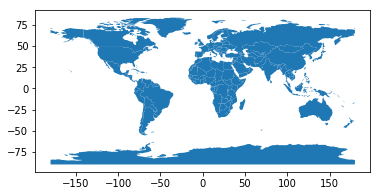

In [32]:
#https://geopandas.org/mapping.html
import geopandas
world = geopandas.read_file(geopandas.datasets.get_path('naturalearth_lowres'))
world.drop(['pop_est', 'continent', 'gdp_md_est'],inplace=True,axis=1)
world.plot();
#geopandas.geoseries.GeoSeries


#Create geometry Dic
#Add 3 letter code e (three letter geo - countriesDic)
#Add geometry